In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import plotly.express as px
import plotly.graph_objects as go

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, recall_score

import shap

In [2]:
# Use params to parse date format
df_employees = pd.read_csv('./datasets/employee_churn_dataset.csv',
                           parse_dates=['data_contratacao', 'data_demissao', 'data_ultimo_feedback',
                                        'data_ultimo_aumento', 'data_ultima_mudanca_cargo'],
                            date_format='%Y-%m-%d')

In [3]:
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [4]:
df_employees.describe()

,idade,data_contratacao,data_demissao,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
count,2000.000000,2000,286,2000.000000,2000,2000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,37.938500,2022-04-13 08:03:07.200000,2023-07-31 15:11:19.720279808,14801.834500,2023-06-24 02:25:26.400000,2023-06-10 23:52:48.000000256,2023-06-23 20:43:26.400000,7.997550,4.984500,3.998500,5.492450,0.14300
min,22.000000,2020-01-02 00:00:00,2020-08-22 00:00:00,5016.000000,2020-02-08 00:00:00,2020-03-26 00:00:00,2020-02-15 00:00:00,6.000000,1.000000,1.000000,1.000000,0.00000
25%,30.000000,2021-02-12 00:00:00,2022-11-03 12:00:00,9844.250000,2022-10-27 18:00:00,2022-09-24 18:00:00,2022-11-03 00:00:00,7.000000,3.000000,2.000000,3.300000,0.00000
50%,38.000000,2022-04-05 00:00:00,2023-12-11 12:00:00,14822.500000,2023-10-03 12:00:00,2023-09-19 00:00:00,2023-10-12 00:00:00,8.000000,5.000000,4.000000,5.500000,0.00000
75%,46.000000,2023-06-14 06:00:00,2024-06-10 18:00:00,19702.500000,2024-05-19 06:00:00,2024-05-13 06:00:00,2024-05-15 06:00:00,9.000000,7.000000,6.000000,7.700000,0.00000
max,54.000000,2024-07-25 00:00:00,2024-10-21 00:00:00,24988.000000,2024-10-23 00:00:00,2024-10-22 00:00:00,2024-10-23 00:00:00,10.000000,9.000000,7.000000,10.000000,1.00000
std,9.456132,NaN,NaN,5763.451836,NaN,NaN,NaN,1.157324,2.593188,1.987076,2.609817,0.35016


In [5]:
df_employees.head(5)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0


# Feature Engineering

In [6]:
# Create features based on the dates (difference between dates)

df_employees['tempo_empresa'] = df_employees.apply(lambda x:
                                                   (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
                                                   else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

# Calculate time between last feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

# Calculate time between last salary raise
df_employees['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employees['data_ultimo_aumento']).dt.days

# Calculate time between last role change
df_employees['dias_desde_ultima_mudanca_cargo'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [7]:
df_employees.head(5)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,...,9.6,True,5,1,7.0,0,1997,408,691,961
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,...,8.4,True,8,4,9.1,0,1996,442,650,1226
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,...,8.5,False,9,7,1.3,0,1995,736,1273,1503
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,...,7.9,False,8,4,8.4,0,1994,1295,1267,295
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,...,7.5,True,5,2,8.2,0,1992,1205,581,317


In [8]:
# Remove ID
df_employees.drop(columns=['id'], axis=1, inplace=True)

# EDA

In [9]:
print("Missing values")
df_employees.isnull().sum()

Missing values


idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
dias_desde_ultimo_feedback            0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [10]:
# Percentage of target distribution
fig = px.bar(df_employees['churn'].value_counts() / len(df_employees) * 100,
             title='Churn Factor',
             labels={'index': 'Churn', 'value': 'Percentual'},
             opacity=0.8)
fig.update_layout(showlegend=False)
fig.show()

In [11]:
# Possible values do categorical features
for col in df_employees.select_dtypes(include=['object']).columns:
    print(f'\nUnique values in {col}:')
    print(df_employees[col].unique())


Unique values in genero:
['F' 'Outro' 'M']

Unique values in estado_civil:
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']

Unique values in educacao:
['Master' 'Technical Degree' 'Bachelor' 'PhD']

Unique values in regime_trabalho:
['Remoto' 'Híbrido' 'Presencial']

Unique values in tipo_demissao:
[nan 'Involuntária' 'Voluntária']

Unique values in cargo:
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [12]:
# Descritive statistics of numerical variables
df_employees.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.00000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1065.94200,727.89900,741.005000,728.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,519.62113,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.00000,241.00000,242.000000,241.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,629.75000,397.75000,403.750000,401.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,1069.00000,626.50000,641.000000,618.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1509.25000,967.25000,1000.250000,961.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1997.00000,1960.00000,1913.000000,1953.000000


### EDA - Numerical Features
Relations between numerical variables and 'churn'

In [13]:
numeric_columns = df_employees.select_dtypes(include=['int64', 'float64']).columns

In [14]:
for col in numeric_columns:
    if col != 'churn':
        fig = px.box(df_employees, x='churn', y=col, title=f'Boxplot of {col} vs Churn', color='churn')
        fig.show()

Correlation Matrix

In [15]:
corr_matrix = df_employees[numeric_columns].corr()

fig = px.imshow(corr_matrix,
                title='Correlation Matrix',
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)

fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 9})
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)
fig.show()

In [16]:
# Dispersion Matrix
fig = px.scatter_matrix(df_employees, dimensions=numeric_columns, color='churn', title='Dispersion Matrix')
fig.update_layout(
    width=1200,
    height=1000,
    title_font=dict(size=14),
    font=dict(size=9)
)

### EDA - Numerical Features
Hypothesis tests between categorial features and target 'churn'

In [17]:
categorical_columns = df_employees.select_dtypes(include=['object']).columns

for col in categorical_columns:
    # 'tipo_demissao' is dependant on churn, but as has a lot of nulls, will apppear as independant so I deleted
    if col == 'tipo_demissao':
        continue
    
    contingency_table = pd.crosstab(df_employees['churn'], df_employees[col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'\nTest Chi-Squared to {col} vs Churn:\n')
    print(f'p-value: {p_value}')

    if p_value <= 0.05:
        print(f'Variables {col} and Churn are not independent')
    else:
        print(f'Variables {col} and Churn are independent')


Test Chi-Squared to genero vs Churn:

p-value: 0.6391382063144609
Variables genero and Churn are independent

Test Chi-Squared to estado_civil vs Churn:

p-value: 0.8332629331272039
Variables estado_civil and Churn are independent

Test Chi-Squared to educacao vs Churn:

p-value: 0.2047514912138827
Variables educacao and Churn are independent

Test Chi-Squared to regime_trabalho vs Churn:

p-value: 0.9751275918764937
Variables regime_trabalho and Churn are independent

Test Chi-Squared to cargo vs Churn:

p-value: 0.4586024122014407
Variables cargo and Churn are independent


In [18]:
# Bar graphs for categorical features vs Churn

for col in categorical_columns:
    if col == 'tipo_demissao':
        continue
    
    fig = px.histogram(df_employees, x=col, color='churn', barmode='group', title=f'Distribution of {col} per Churn')
    fig.show()

## Preparing data

In [19]:
# Preparing features and target

# Create list of columns of type datetime
data_columns = list(df_employees.select_dtypes(include=['datetime64']).columns)

# X and y
X = df_employees.drop(['churn', 'tipo_demissao'] + data_columns, axis=1)
y = df_employees['churn']

In [20]:
# Create preprocessor to modify data

# Recreate column list to remove unnecessary features already removed in X, such as 'tipo_demissao'
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [21]:
# Split data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

# Apply the transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) # preprocessor is already fit

print(X_train.shape)
print(X_test.shape)

(1000, 32)
(1000, 32)


# Train Model - Baseline
Only using default hyperparams to stabilish initial metrics and compare with more robust approach later

In [22]:
# Create RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20, # the indicated default is None in the beginning
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=51,
)

In [23]:
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Post Training - Metric Analysis - Baseline

In [24]:
# Make predictions (classifications - 0 or 1) with test group
y_pred = rf_model.predict(X_test)

In [25]:
# Return probabilities of previsions (will be used to calculate some metrics)
y_pred_proba = rf_model.predict_proba(X_test)

In [26]:
# Model evaluation
print("Classfication Report")
print(classification_report(y_test, y_pred))

Classfication Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       855
           1       1.00      0.57      0.73       145

    accuracy                           0.94      1000
   macro avg       0.97      0.79      0.85      1000
weighted avg       0.94      0.94      0.93      1000



In [27]:
# Return values from ROC curve - TPR vs. FPR and Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [28]:
# Calculate AUC (Are Under the Curve)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:, 1])

In [29]:
# Plot ROC curve with AUC value
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Cuve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
     x0=0,
     x1=1,
     y0=0,
     y1=1,
)

fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1)

fig.show()

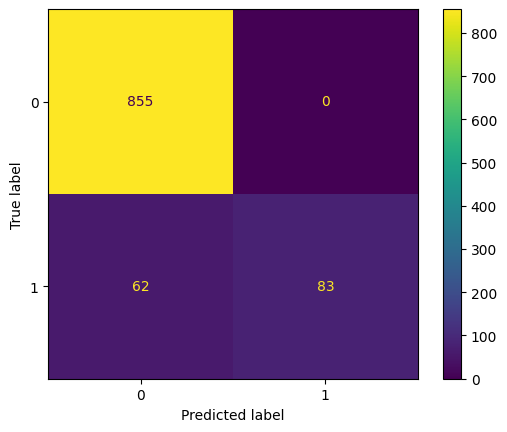

In [30]:
# Show confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [31]:
# Calculate log-loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba)}')

Log Loss: 0.18654661032989855


# Train Model - Cross Validation and Hyperparams Tunning

In [32]:
# Create dict with hyperparameters to be used
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
}

In [33]:
# Configure GridSearchCV with 5 folds (with StratifiedKFold) and maximize recall
rf_model_cv = RandomForestClassifier(class_weight='balanced', random_state=51)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=1)

In [34]:
# Train model using cross validation to search best hyperparams
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,estimator,RandomForestC...ndom_state=51)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


Using cross-validation concept, I worked with Train + Val + Test -> 4 partitions to train + 1 to val
I'll validate best model using X_test

### Metric Analysis - GridSearchCV

In [35]:
# Return best model
best_model = grid_search.best_estimator_

# Return best hyperparameters
best_params = grid_search.best_params_

# Show best hyperparams
best_params

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [36]:
# Return best metric
best_score = grid_search.best_score_

# Show best metric (Recall)
best_score

np.float64(0.7238916256157635)

In [37]:
# Make predictions (classifications - 0 or 1) with test group
y_pred_gridsearch = best_model.predict(X_test)

In [38]:
# Return probabilities of previsions (will be used to calculate some metrics)
y_pred_proba_gridsearch = best_model.predict_proba(X_test)

In [39]:
# Model evaluation
print("Classfication Report")
print(classification_report(y_test, y_pred_gridsearch))

Classfication Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       855
           1       0.98      0.72      0.83       145

    accuracy                           0.96      1000
   macro avg       0.97      0.86      0.90      1000
weighted avg       0.96      0.96      0.95      1000



In [40]:
# Return values from ROC curve - TPR vs. FPR and Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gridsearch[:, 1])

In [41]:
# Calculate AUC (Are Under the Curve)
roc_auc  = roc_auc_score(y_test, y_pred_proba_gridsearch[:, 1])

In [42]:
# Plot ROC curve with AUC value
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Cuve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
     x0=0,
     x1=1,
     y0=0,
     y1=1,
)

fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1)

fig.show()

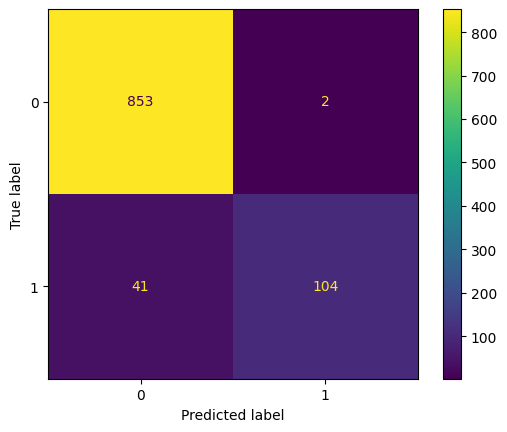

In [43]:
# Show confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_gridsearch)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [44]:
# Calculate log-loss
print(f'Log Loss: {log_loss(y_test, y_pred_proba_gridsearch)}')

Log Loss: 0.28838924732090565


ROC Curve and log loss got worst, what means that, even predicting less false-negatives (recall is better), there are more predicts without so much confidence.

# Adjust by Threshold
By default, the random forest threshold is 0.5 but it's possible to adjust it. In this section I'll try to adjust threshold to verify if there's one that can make my Recall higher

In [45]:
# Create a lista of thresholds to test
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]

# List do store recalls
recalls = []

# Calculate metrics based on each threshold
for threshold in threshold_list:
    # Make predictions with threshold
    # if probability to be 1 is greater than threshold, I consider it as being 1
    y_pred_threshold = (y_pred_proba_gridsearch[:, 1] >= threshold).astype(int)

    # Calculate recall
    recall = recall_score(y_test, y_pred_threshold)

    # Insert metrics in the list
    recalls.append(recall)

In [46]:
# Create dataframe with recalls list
df_thresholds = pd.DataFrame({'Threshold': threshold_list, 'Recall': recalls})
df_thresholds.head(5)

,Threshold,Recall
0,0.3,0.882759
1,0.4,0.834483
2,0.5,0.717241
3,0.6,0.503448
4,0.7,0.358621


In [47]:
# Find threshold with best recall
best_threshold = df_thresholds.loc[df_thresholds['Recall'].idxmax()]

print(f'Best Threshold: {best_threshold['Threshold']:.2f}')
print(f'Highest Recall: {best_threshold['Recall']:.4f}')

Best Threshold: 0.30
Highest Recall: 0.8828


In [48]:
# Plot Graphs from Thresholds
fig = go.Figure()
fig.add_trace(go.Scatter(x=threshold_list, y=recalls, name='Recall', line=dict(color='blue')))
fig.update_layout(
    title='Recall by Thresholds',
    xaxis_title='Threshold',
    yaxis_title='Recall Score',
    width=800,
    height=500
)
fig.show()

## Metric Analysis - Threshold

In [49]:
y_pred_threshold = (y_pred_proba_gridsearch[:, 1] >= best_threshold['Threshold']).astype(int)

In [50]:
# Model evaluation
print("Classification Report")
print(classification_report(y_test, y_pred_threshold))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       855
           1       0.54      0.88      0.67       145

    accuracy                           0.87      1000
   macro avg       0.76      0.88      0.79      1000
weighted avg       0.91      0.87      0.88      1000



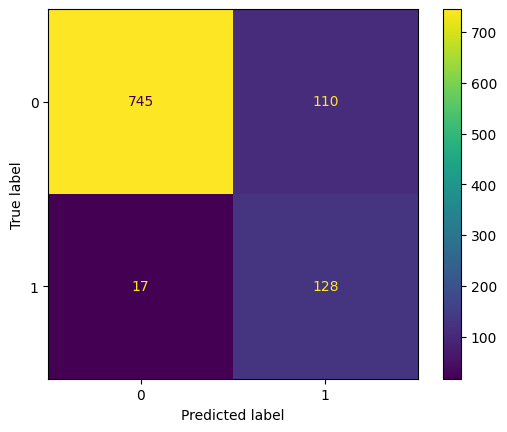

In [51]:
# Confusion Matrix with best threshold
conf_matrix = confusion_matrix(y_test, y_pred_threshold)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

## Calculate feature importance

In [52]:
importances = best_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Create dataframe with importances and feature names
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Order dataframe by importance (desc)
df_importances = df_importances.sort_values('importance', ascending=False).reset_index(drop=True)

In [53]:
fig = px.bar(
    df_importances.head(10),
    x='importance',
    y='feature',
    orientation='h',
    title='10 Main Features',
    labels={'importance': 'Importance', 'feature': 'Feature'},
    color='importance',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'},
)

fig.show()

In [54]:
# Visualize Random Forest trees
def visualize_tree(model, index_tree, max_depth=5):
    plt.figure(figsize=(20, 10))
    plot_tree(model.estimators_[index_tree],
              feature_names=feature_names,
              class_names=['0', '1'],
              filled=True,
              rounded=True,
              max_depth=max_depth,
              fontsize=9,
              proportion=True,
              precision=2)
    plt.title(f'Tree {index_tree + 1} from Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()

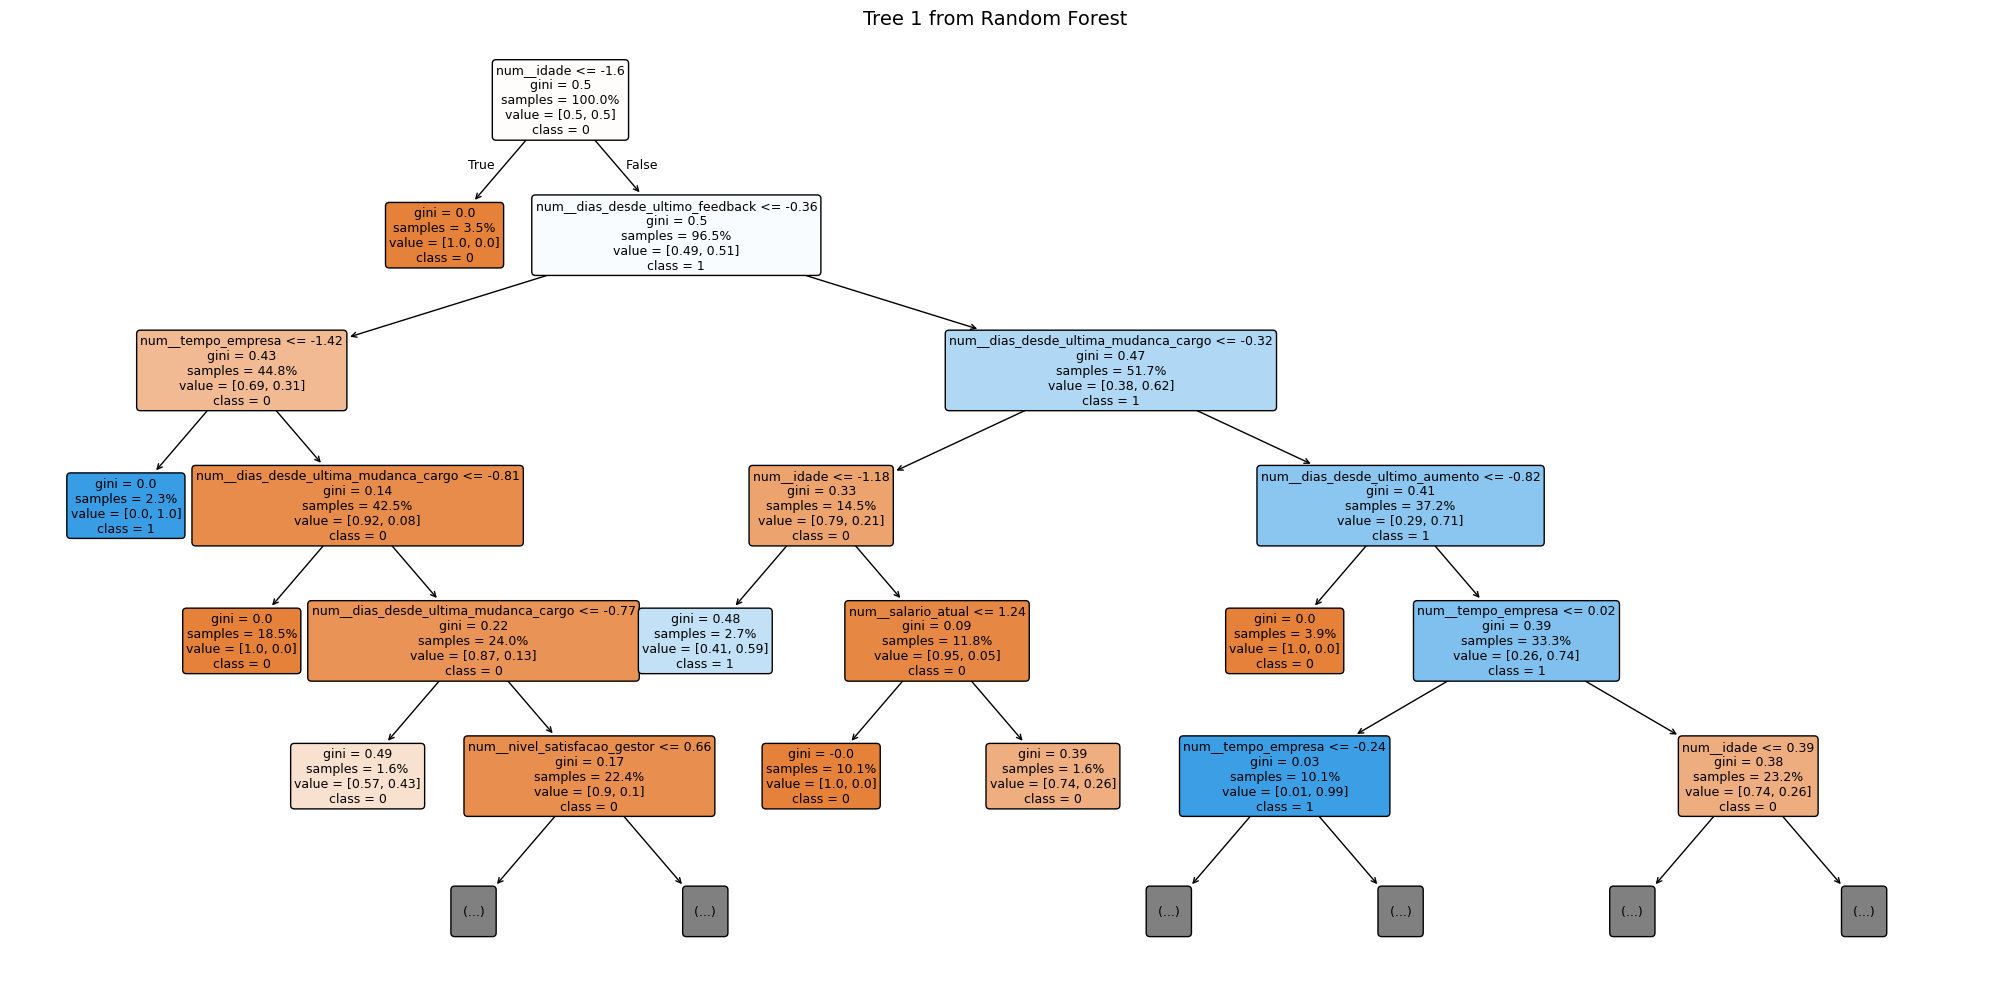

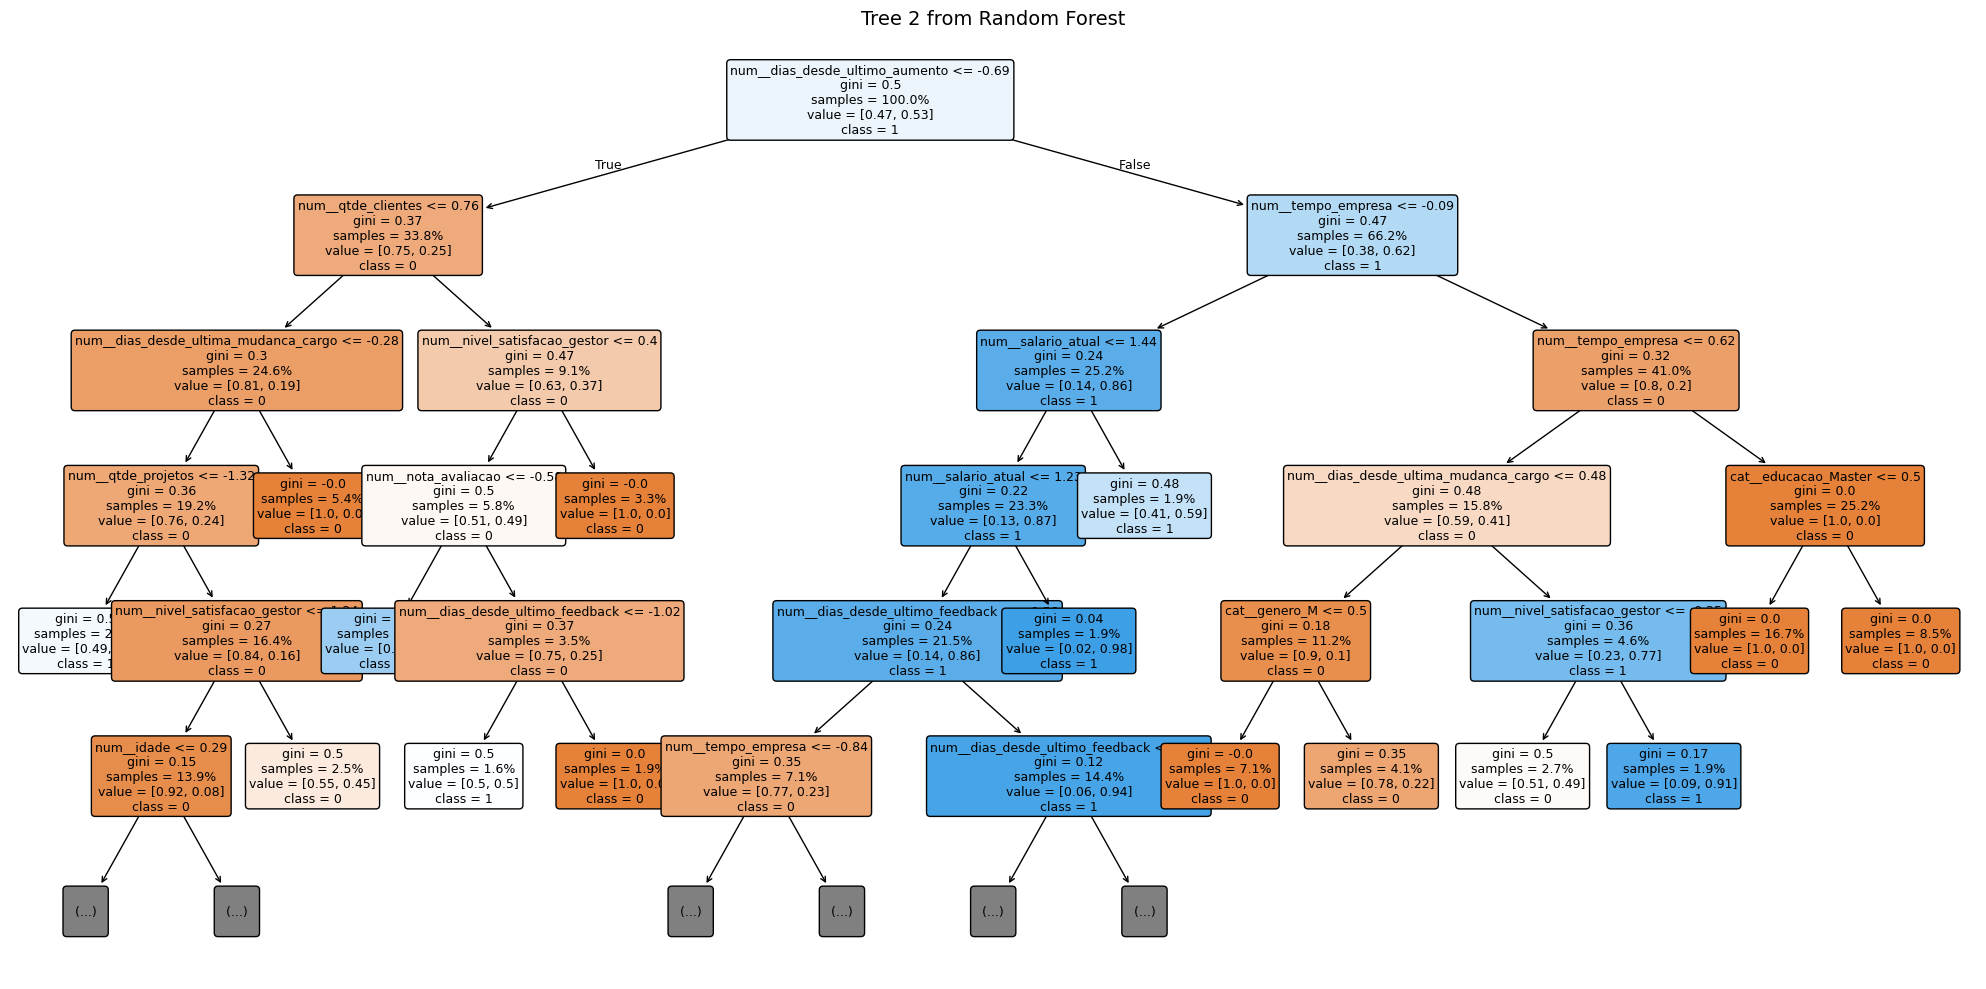

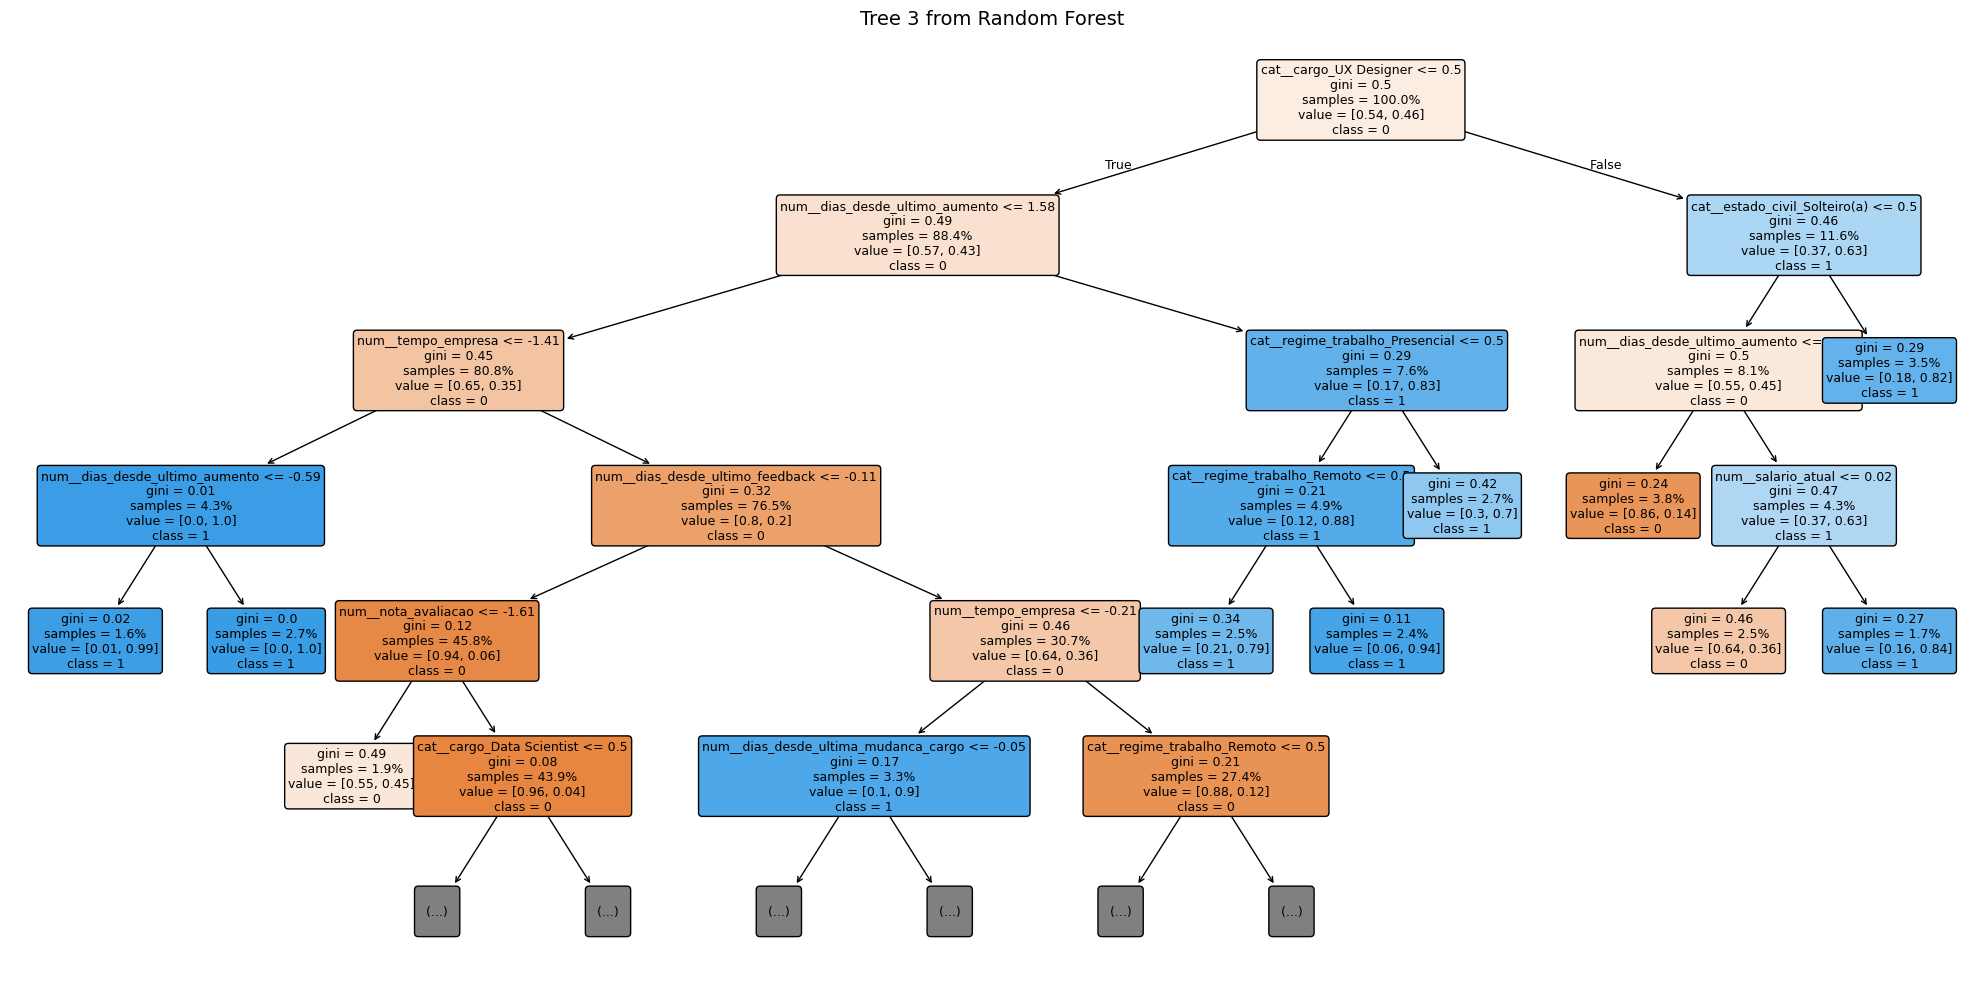

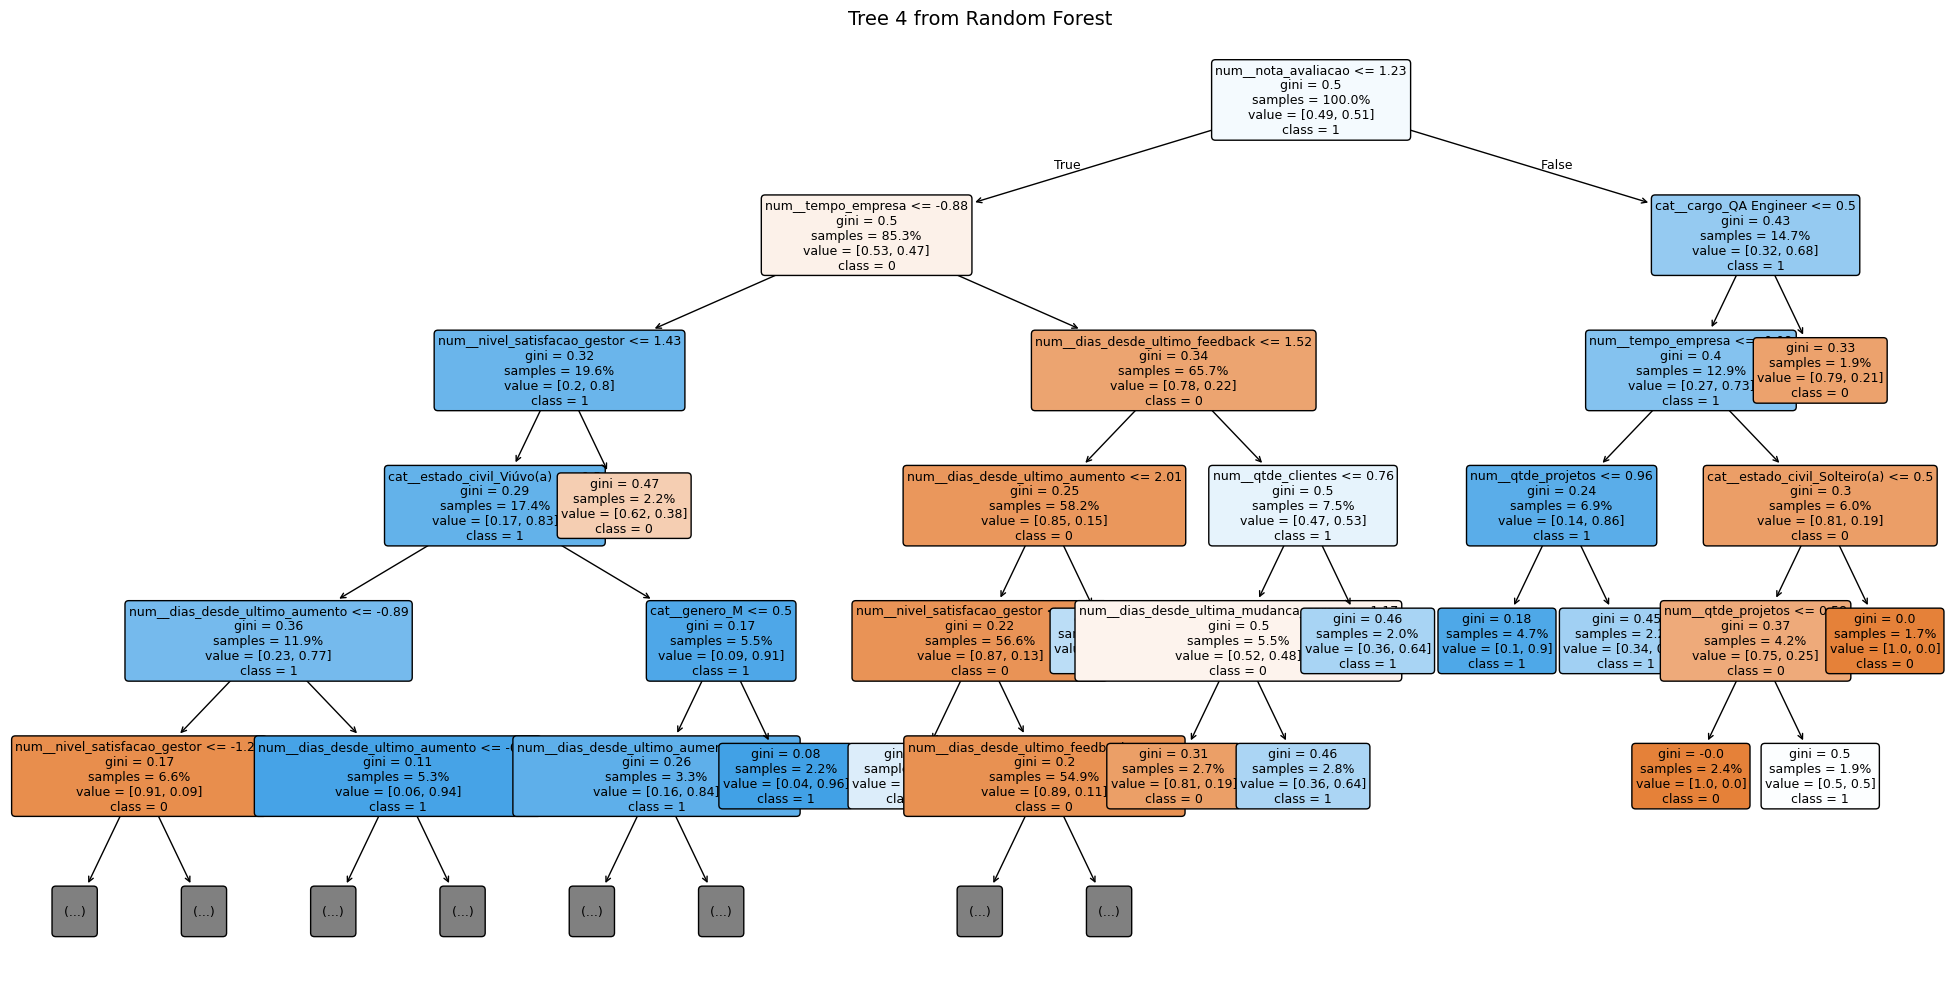

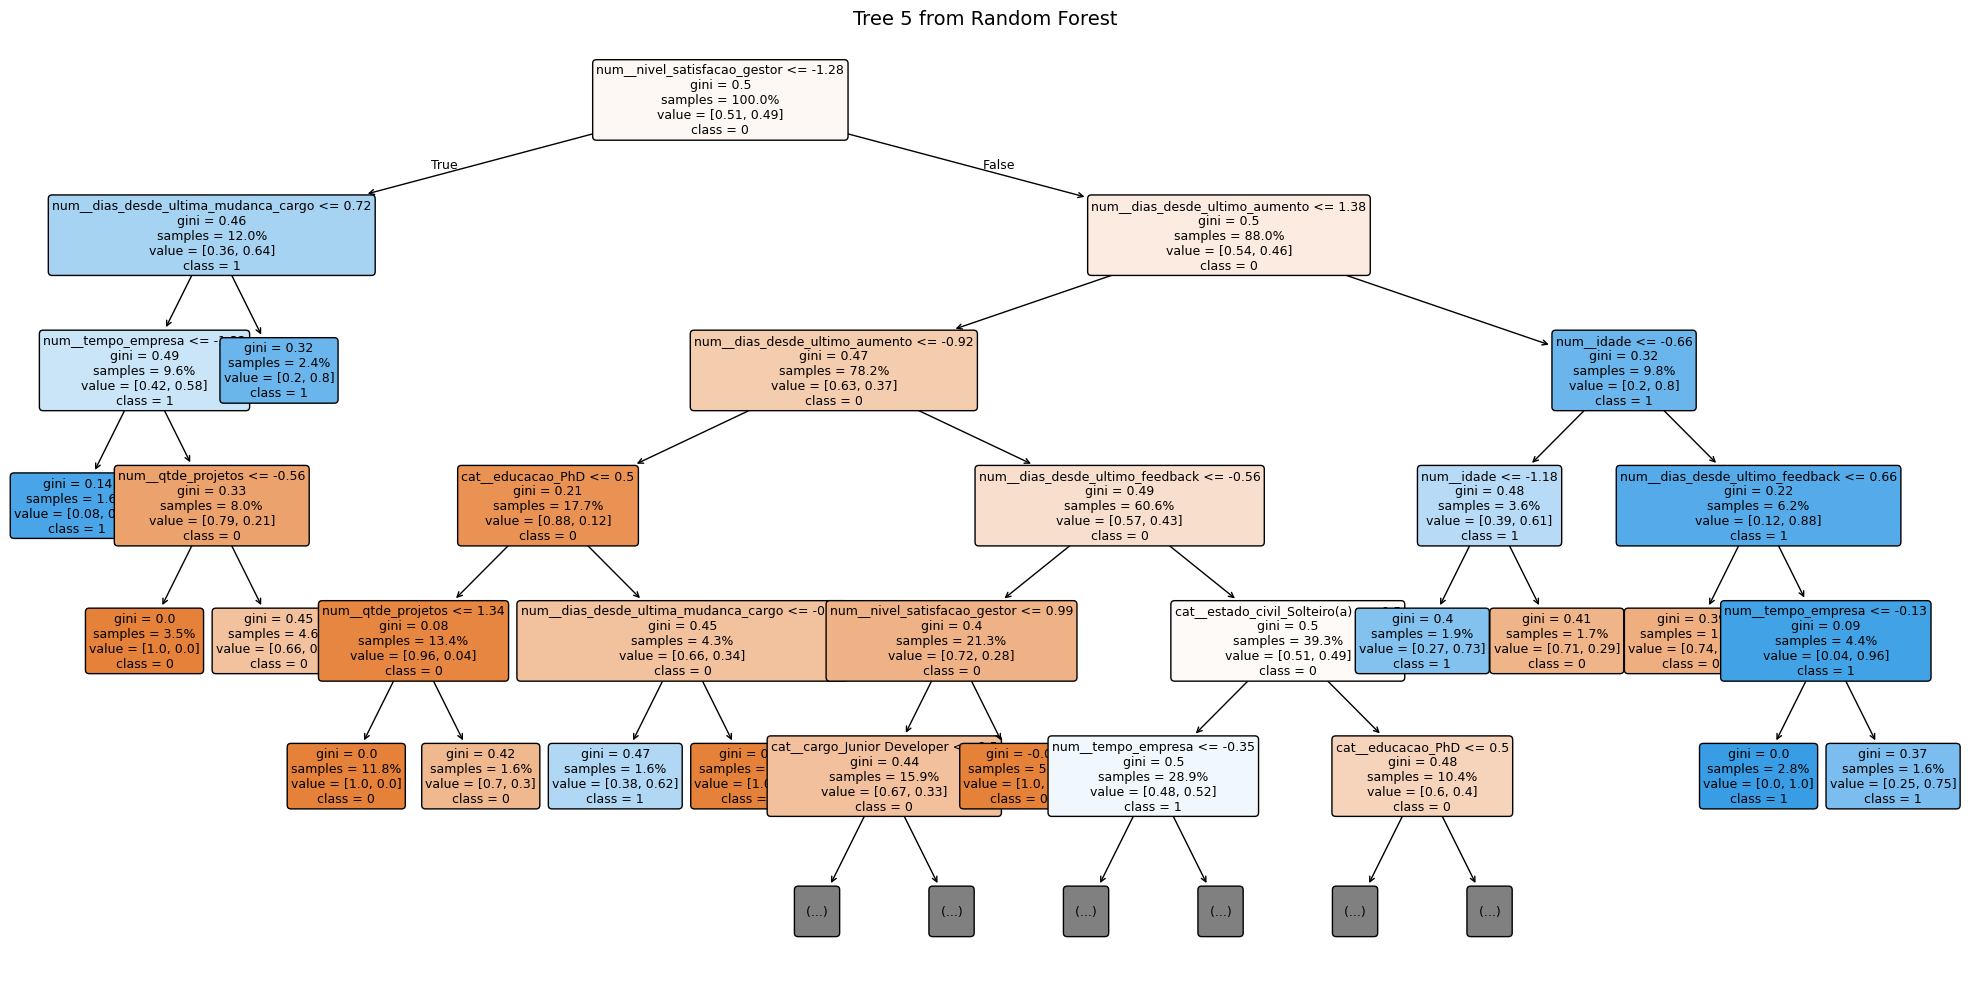

In [55]:
# See first 5 trees
for i in range(5):
    visualize_tree(best_model, i)

## Calculate Shap Values

In [56]:
# Run explainer with train data
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=feature_names)

# Calculate Shapley Values in test data
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [02:01,  7.66it/s]                          


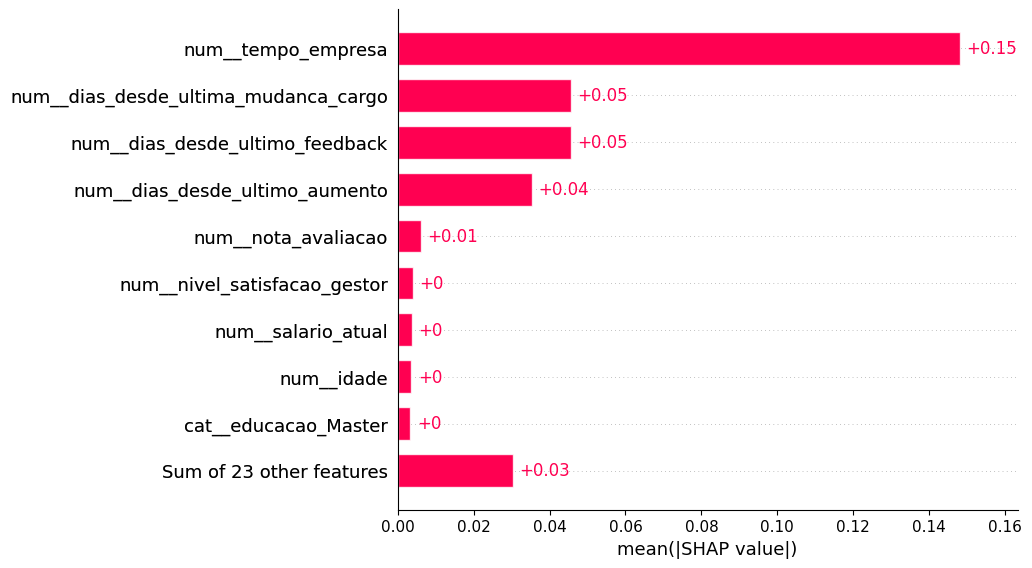

In [57]:
# Plot global contribution by shap values
shap.plots.bar(shap_values_class)

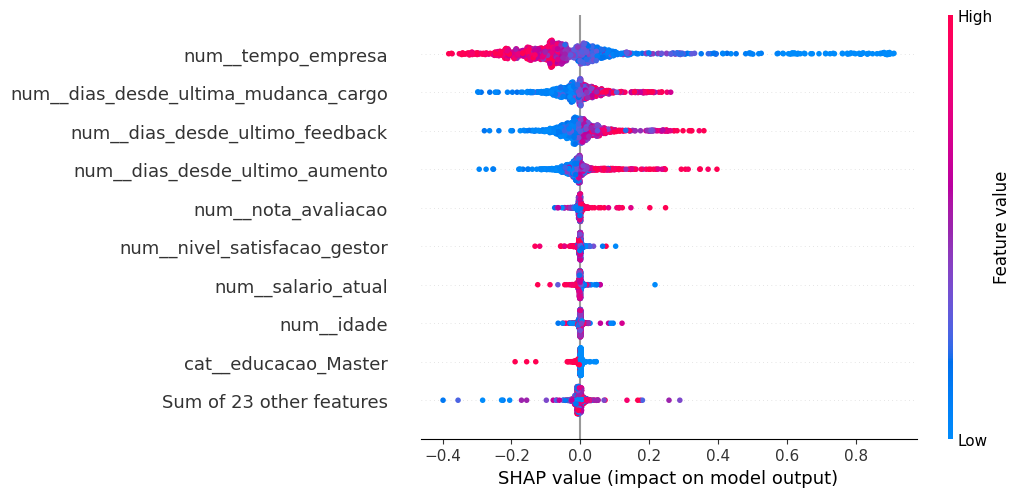

In [58]:
# Global Beeswarm Plot
shap.plots.beeswarm(shap_values_class, max_display=10)

Analyze of shap values for especific situation: one example of false negative

In [59]:
# Create DF containing y_test and y_pred
df_comparation = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_threshold})
df_comparation

,y_test,y_pred
1617,0,0
885,0,0
433,0,0
188,0,1
1264,0,1
...,...,...
784,0,0
1914,0,0
227,1,0
316,1,1


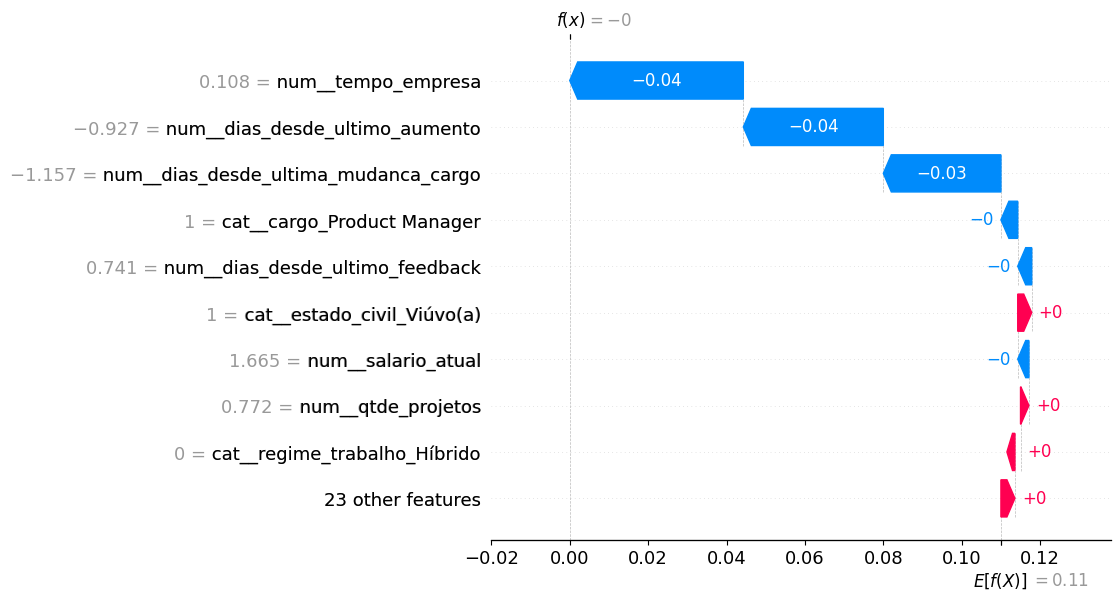

In [60]:
# Plot Shap Values
shap.plots.waterfall(shap_values_class[227], max_display=10)

## Save Model

In [61]:
import joblib 

joblib.dump(preprocessor, './models/churn_preprocessor.pkl')
joblib.dump(best_model, './models/churn_model.pkl')

['./models/churn_model.pkl']